In [80]:
import ctypes
import os
from ctypes import *

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [81]:
path_to_dll = "C:/Users/Maathess/Desktop/Projet_annuel_flag/PMC/cmake-build-debug/PMC1.dll"
mylib = cdll.LoadLibrary(path_to_dll)

In [82]:
def import_images_and_assign_labels(
        folder, label, X, Y
):
    for file in os.listdir(folder):
        image_path = os.path.join(folder, file)
        im = Image.open(image_path)
        im = im.resize((32, 32))
        im = im.convert("RGB")
        im_arr = np.array(im)
        im_arr = np.reshape(im_arr, (32 * 32 * 3))
        X.append(im_arr)
        Y.append(label)


def import_dataset():
    dataset_folder = "C:/Users/Maathess/Desktop/Projet_annuel_flag/Datasets"
    train_folder = os.path.join(dataset_folder, "Train")
    test_folder = os.path.join(dataset_folder, "Test")

    X_train = []
    y_train = []
    import_images_and_assign_labels(
        os.path.join(train_folder, "french_flag"), 1.0, X_train, y_train
    )
    import_images_and_assign_labels(
        os.path.join(train_folder, "brazil_flag"), -1.0, X_train, y_train
    )
    X_test = []
    y_test = []
    import_images_and_assign_labels(
        os.path.join(test_folder, "french_flag"), 1.0, X_test, y_test
    )
    import_images_and_assign_labels(
        os.path.join(test_folder, "brazil_flag"), -1.0, X_test, y_test
    )

    return (np.array(X_train) / 255.0, np.array(y_train)), \
           (np.array(X_test) / 255.0, np.array(y_test))


In [105]:
def run():
    (X_train, y_train), (X_test, y_test) = import_dataset()
    dataset_inputs = np.array(X_train)
    dataset_expected_outputs = np.array(y_train)

    init_tab = [2, 3]
    init_size = len(init_tab)
    init_type = c_int * init_size
    init = init_type(*init_tab)

    mylib.create_mlp_model.argtypes = [init_type, c_int]
    mylib.create_mlp_model.restype = c_void_p

    model = mylib.create_mlp_model(init, int(init_size))
    test_dataset = X_test
    colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in dataset_expected_outputs]

    mylib.getXSize.argtypes = [c_void_p]
    mylib.getXSize.restype = c_int
    tmp_len = mylib.getXSize(model)

    flattened_dataset_inputs = []
    for p in dataset_inputs :
        flattened_dataset_inputs.append(p[0])
        flattened_dataset_inputs.append(p[1])

    arrsize_flat = len(flattened_dataset_inputs)
    arrtype_flat = c_float * arrsize_flat
    arr_flat = arrtype_flat(*flattened_dataset_inputs)

    arrsize_exp = len(dataset_expected_outputs)
    arrtype_exp = c_float * arrsize_exp
    arr_exp = arrtype_exp(*dataset_expected_outputs)
    
    predicted_outputs = []
    for p in test_dataset :
        arrsizeP = len(p)
        arrtypeP = c_float * arrsizeP
        arrP = arrtypeP(*p)
        mylib.predict_mlp_model_classification.argtypes = [c_void_p, arrtypeP]
        mylib.predict_mlp_model_classification.restype = POINTER(c_float)
        tmp = []

        tmp = mylib.predict_mlp_model_classification(model, arrP)
        np_arr = np.ctypeslib.as_array(tmp, (tmp_len,))
        predicted_outputs.append(np_arr[0])
    
    predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in predicted_outputs]
    plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
    plt.scatter([p[0] for p in dataset_inputs], [p[1] for p in dataset_inputs], c=colors, s=200)
    plt.show()

    print(predicted_outputs)
    print("_______")
    print(dataset_expected_outputs)

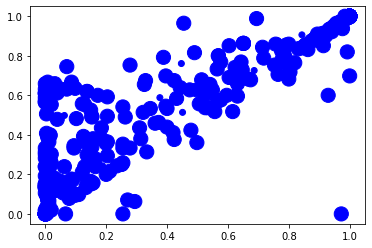

[-0.7615942, -0.09772637, 0.7615942, 0.035279408, 0.47588193, 0.37994897, -0.7582805, -0.38997006, 0.7615942, 0.19737528, -0.7615942, -0.7615942, -0.7615942, 0.60312176, 0.6895298, -0.73755574, 0.69565105, -0.7615942, -0.7615942, 0.60062075, -0.23845686, 0.69565105, 0.7615942, 0.66839874, -0.7615942, -0.7266386, -0.7615942, 0.5879386, -0.52009547, 0.67485636, -0.09384072, -0.23845686, 0.1746612, -0.7615942, -0.7582805, 0.7615942, -0.7582805, 0.5143506, -0.54811746, 0.7134215, 0.66839874, 0.6322154, -0.7303195, -0.7303195, -0.7615942, -0.7582805, -0.7615942, -0.72103816, -0.7615942, 0.5955834, 0.035279468, 0.39989957, 0.7615942, -0.7615942, -0.7615942, 0.7481005, 0.24215192, -0.7615942, -0.7615942, 0.69565105, 0.37321812, 0.65067625, -0.7615942, 0.7615942, 0.36983788, -0.7615942, -0.4449865, -0.7411117, 0.7615942, -0.7549272, 0.36983788, 0.36983788, -0.56436527, -0.7615942, -0.65962917, -0.7615942, 0.41299412, -0.7615942, 0.7615942, -0.7615942, 0.7481005, 0.4064677, 0.3109246, -0.634563

In [106]:
if __name__ == "__main__":
    run()

In [120]:
def run_train():
    (X_train, y_train), (X_test, y_test) = import_dataset()
    dataset_inputs = np.array(X_train)
    dataset_expected_outputs = np.array(y_train)

    init_tab = [1,32]
    init_size = len(init_tab)
    init_type = c_int * init_size
    init = init_type(*init_tab)

    mylib.create_mlp_model.argtypes = [init_type, c_int]
    mylib.create_mlp_model.restype = c_void_p

    model1 = mylib.create_mlp_model(init, int(init_size))
    test_dataset = X_test
    colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in dataset_expected_outputs]

    mylib.getXSize.argtypes = [c_void_p]
    mylib.getXSize.restype = c_int
    tmp_len = mylib.getXSize(model1)

    flattened_dataset_inputs = []
    for p in dataset_inputs :
        flattened_dataset_inputs.append(p[0])
        flattened_dataset_inputs.append(p[1])

    arrsize_flat = len(flattened_dataset_inputs)
    arrtype_flat = c_float * arrsize_flat
    arr_flat = arrtype_flat(*flattened_dataset_inputs)

    arrsize_exp = len(dataset_expected_outputs)
    arrtype_exp = c_float * arrsize_exp
    arr_exp = arrtype_exp(*dataset_expected_outputs)
    
    predicted_outputs = []
    for p in test_dataset :
        arrsizeP = len(p)
        arrtypeP = c_float * arrsizeP
        arrP = arrtypeP(*p)
        mylib.predict_mlp_model_classification.argtypes = [c_void_p, arrtypeP]
        mylib.predict_mlp_model_classification.restype = POINTER(c_float)
        tmp = []

        tmp = mylib.predict_mlp_model_classification(model1, arrP)
        np_arr = np.ctypeslib.as_array(tmp, (tmp_len,))
        predicted_outputs.append(np_arr[0])
    flattened_dataset_inputs = []
    for p in dataset_inputs :
        flattened_dataset_inputs.append(p[0])
        flattened_dataset_inputs.append(p[1])

    # definition de train_classification_stochastic_gradient....
    arrsize_flat = len(flattened_dataset_inputs)
    arrtype_flat = c_float * arrsize_flat
    arr_flat = arrtype_flat(*flattened_dataset_inputs)

    arrsize_exp = len(dataset_expected_outputs)
    arrtype_exp = c_float * arrsize_exp
    arr_exp = arrtype_exp(*dataset_expected_outputs)
    
    print(predicted_outputs)
    print("_______")

    mylib.train_classification_stochastic_gradient_backpropagation_mlp_model.argtypes = [c_void_p, arrtype_flat, c_int,
                                                                                         arrtype_exp, c_float, c_int]
    mylib.train_classification_stochastic_gradient_backpropagation_mlp_model.restype = None

    mylib.train_classification_stochastic_gradient_backpropagation_mlp_model(model1, arr_flat, arrsize_flat, arr_exp,
                                                                             0.001, 10000)
    predicted_outputs = []
    for p in test_dataset :
        arrsizeP = len(p)
        arrtypeP = c_float * arrsizeP
        arrP = arrtypeP(*p)
        mylib.predict_mlp_model_classification.argtypes = [c_void_p, arrtypeP]
        mylib.predict_mlp_model_classification.restype = POINTER(c_float)
        tmp = []

        tmp = mylib.predict_mlp_model_classification(model1, arrP)
        np_arr = np.ctypeslib.as_array(tmp, (tmp_len,))
        predicted_outputs.append(np_arr[0])

    predicted_outputs_colors = ["blue" if np.argmax(output) == 0 else ("red" if np.argmax(output) == 1 else "green") for output in predicted_outputs]
    plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
    plt.scatter([p[0] for p in dataset_inputs], [p[1] for p in dataset_inputs], c=colors, s=200)
    plt.show()

    flattened_dataset_inputs = []
    for p in dataset_inputs :
        flattened_dataset_inputs.append(p[0])
        flattened_dataset_inputs.append(p[1])
        
        
    print(predicted_outputs)
    print("_______")
    print(dataset_expected_outputs)

    mylib.destroy_MLP(model1)

[0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942, 0.7615942

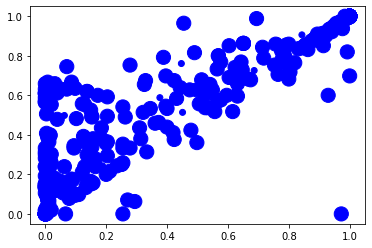

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
_______
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 

In [122]:
if __name__ == "__main__":
    run_train()